In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import  math
from sklearn.model_selection import cross_validate,train_test_split
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import sys
from numpy import genfromtxt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from __future__ import division
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score
import xgboost
import math
import xgboost
import warnings
warnings.filterwarnings("ignore")


##### Read the data

In [50]:
encode = pd.read_csv("encode.csv")
clip = pd.read_csv("clip.csv") 
scenechange = pd.read_csv("scene_change.csv") 

##### Add prefix to distinguish the tables after merging 

In [51]:
clip=clip.add_prefix('clip_')

In [52]:
scene_df = pd.DataFrame(columns=['clip_id','averagescenechange'])

##### Calculate scene change percentage in one second

In [53]:
scenechange = scenechange[~scenechange['clip_id'].isnull()]
clip_id = scenechange['clip_id'].unique()
j = 0;
for i in clip_id:
    j = j + 1;
    scene_df.loc[j] = [i , np.sum(scenechange[scenechange['clip_id']==i]['percentage'])]

##### Get the last part of the names in 'clip_filename' for simplification 

In [54]:
clip= clip.dropna(subset=['clip_filename'])
size=clip['clip_filename'].shape[0]
for i in range(size):
    txt=clip['clip_filename'][i]
    out = txt.split("/")
    clip['clip_filename'][i]=out[-1]

##### Change the form of values from fractional to integer in 'clip_frame_rate' 

In [55]:
size=clip['clip_frame_rate'].shape[0]
for i in range(size):
    txt=clip['clip_frame_rate'][i]
    out = txt.split("/")
    clip['clip_frame_rate'][i]=float(out[0])/float(out[1])
#clip.head()

##### Add prefix to distinguish the tables after merging 

In [39]:
encode=encode.add_prefix('encode_')
#encode.head()

##### Merge the tables Clip, Encode and Scene change


In [10]:
encode_clip=encode.merge(clip, left_on='encode_clip_id', right_on='clip_id',how='left')
encode_clip_scene = encode_clip.merge(scene_df,left_on='clip_id', right_on='clip_id',how='left')

##### Calculate the resolution, width times hight 

In [11]:
encode_WidthHeight= encode_clip_scene['encode_width']*encode_clip_scene['encode_height']

##### As the clips duration are not the same, by dividing the 'averagescenechange' by 'clip_duration', the average scenechange for one second is calculated  

In [12]:
scenechange_avg= encode_clip_scene['averagescenechange']/encode_clip_scene['clip_duration']

##### Select the desired features from the merged tables 

In [13]:
df=pd.DataFrame({'averagescenechange': scenechange_avg,'clip_duration': encode_clip_scene['clip_duration'], 'clip_filename':encode_clip_scene['clip_filename'],'clip_frame_rate':encode_clip_scene['clip_frame_rate'], 'clip_height': encode_clip_scene['clip_height'], 'clip_size': encode_clip_scene['clip_size'], 'encode_WidthHeight': encode_WidthHeight,'encode_bitrate_video': encode_clip_scene['encode_bitrate_video'], 'encode_crf': encode_clip_scene['encode_crf'], 'clip_width' : encode_clip_scene['clip_width'],  'encode_vmaf': encode_clip_scene['encode_vmaf']})
df.dropna(inplace=True)
df.head()

,averagescenechange,clip_duration,clip_filename,clip_frame_rate,clip_height,clip_size,encode_WidthHeight,encode_bitrate_video,encode_crf,clip_width,encode_vmaf
133,0.710526,19,aspen_1080p_crf5.mp4,29.97,1080,378608416,2073600,31965055.0,18,1920,96.812706
134,0.710526,19,aspen_1080p_crf5.mp4,29.97,1080,378608416,2073600,26317390.0,19,1920,96.012268
135,0.710526,19,aspen_1080p_crf5.mp4,29.97,1080,378608416,2073600,21645223.0,20,1920,95.102669
136,0.710526,19,aspen_1080p_crf5.mp4,29.97,1080,378608416,2073600,12617049.0,23,1920,91.863864
137,0.710526,19,aspen_1080p_crf5.mp4,29.97,1080,378608416,2073600,9134862.0,25,1920,89.166648


##### Apply the method ITU-T P.1401 on 'encode_bitrate_video' to remove the extreme outliers

In [15]:
shape=df['encode_bitrate_video'].shape[0]
IQR=df['encode_bitrate_video'].describe()[6]-df['encode_bitrate_video'].describe()[4]
IQR2=IQR*3
threshold=df['encode_bitrate_video'].describe()[6]+IQR2
for i in range(shape):
    if(df.iloc[i, 7:8].values[0] >= threshold):
        df.iloc[i, 7:8]=np.nan
        #df.at[i, 3:4] = 0

df.dropna(inplace=True)
df.head()

,averagescenechange,clip_duration,clip_filename,clip_frame_rate,clip_height,clip_size,encode_WidthHeight,encode_bitrate_video,encode_crf,clip_width,encode_vmaf
146,0.710526,19,aspen_1080p_crf5.mp4,29.97,1080,378608416,2073600,1754686.0,37,1920,56.769344
147,0.710526,19,aspen_1080p_crf5.mp4,29.97,1080,378608416,2073600,1218860.0,40,1920,45.265158
148,0.710526,19,aspen_1080p_crf5.mp4,29.97,1080,378608416,2073600,860291.0,43,1920,33.766199
149,0.710526,19,aspen_1080p_crf5.mp4,29.97,1080,378608416,2073600,678211.0,45,1920,26.760924
150,0.710526,19,aspen_1080p_crf5.mp4,29.97,1080,378608416,2073600,372258.0,50,1920,11.814692


##### Apply the method ITU-T P.1401 on 'averagescenechange' to remove the extreme outliers 

In [16]:
shape=df['averagescenechange'].shape[0]
IQR=df['averagescenechange'].describe()[6]-df['averagescenechange'].describe()[4]
IQR2=IQR*3
threshold=df['averagescenechange'].describe()[6]+IQR2
for i in range(shape):
    if(df.iloc[i, 0:1].values[0] >= threshold):
        df.iloc[i, 0:1]=np.nan
        #df.at[i, 3:4] = 0

df.dropna(inplace=True)
df.shape

(4727, 11)

##### Apply the method ITU-T P.1401 on 'clip_size' to remove the extreme outliers 

In [17]:
# Apply the method ITU-T P.1401 to remove the extreme outliers(Using IQR(Interquartile Range)*3 instead of IQR*1.5)
shape=df['clip_size'].shape[0]
IQR=df['clip_size'].describe()[6]-df['clip_size'].describe()[4]
IQR2=IQR*3
threshold=df['clip_size'].describe()[6]+IQR2
for i in range(shape):
    if(df.iloc[i, 5:6].values[0] >= threshold):
        df.iloc[i, 5:6]=np.nan
        #df.at[i, 3:4] = 0

df.dropna(inplace=True)
df.shape

(4409, 11)

##### Apply the method ITU-T P.1401 on 'clip_duration' to remove the extreme outliers 

In [18]:
# Apply the method ITU-T P.1401 to remove the extreme outliers(Using IQR(Interquartile Range)*3 instead of IQR*1.5)
shape=df['clip_duration'].shape[0]
IQR=df['clip_duration'].describe()[6]-df['clip_duration'].describe()[4]
IQR2=IQR*3
threshold=df['clip_duration'].describe()[6]+IQR2
for i in range(shape):
    if(df.iloc[i, 1:2].values[0] >= threshold):
        df.iloc[i, 1:2]=np.nan
        #df.at[i, 3:4] = 0

df.dropna(inplace=True)
df.head()

,averagescenechange,clip_duration,clip_filename,clip_frame_rate,clip_height,clip_size,encode_WidthHeight,encode_bitrate_video,encode_crf,clip_width,encode_vmaf
545,0.710526,19.0,aspen_1080p_crf10.mp4,29.97,1080,231039918.0,2073600,1753019.0,37,1920,56.929568
546,0.710526,19.0,aspen_1080p_crf10.mp4,29.97,1080,231039918.0,2073600,1215713.0,40,1920,45.382016
547,0.710526,19.0,aspen_1080p_crf10.mp4,29.97,1080,231039918.0,2073600,859852.0,43,1920,33.900708
548,0.710526,19.0,aspen_1080p_crf10.mp4,29.97,1080,231039918.0,2073600,679391.0,45,1920,26.724971
549,0.710526,19.0,aspen_1080p_crf10.mp4,29.97,1080,231039918.0,2073600,370787.0,50,1920,11.386264


##### Main loop to make one-hold-out cross validation

In [19]:
ClipName = df['clip_filename'].unique()

# Create two empty matrices for Confidence & Predicted values for all used models
confidence_SVR = np.empty([ClipName.size])
predict_SVR=np.empty([1])

confidence_LiReg = np.empty([ClipName.size])
predict_LiReg=np.empty([1])

confidence_RF = np.empty([ClipName.size])
predict_RF=np.empty([1])

confidence_XGB = np.empty([ClipName.size])
predict_XGB=np.empty([1])

target_yTest = np.empty([1])
target_XTest = np.empty([1,9])

New_clip_filename=pd.DataFrame()
Old_clip_filename=pd.DataFrame()

for i in range(2):#ClipName.size:
    df_test = df[df['clip_filename'].isin(ClipName[i:i+1])]
    df_train = df[df['clip_filename'].isin(ClipName[i:i+1])==False]
    Old_clip_filename = df_test['clip_filename']
    
    df_train = df_train.drop(['clip_filename'], axis=1);
    df_test = df_test.drop(['clip_filename'], axis=1);
    train_num = df_train.shape[0]
    
    # Splite the data into train and test set
    X_train = np.array(df_train.drop(['encode_vmaf'], 1))
    y_train = np.array(df_train['encode_vmaf'])
    
    X_test = np.array(df_test.drop(['encode_vmaf'], 1))
    y_test = np.array(df_test['encode_vmaf'])
    X_test_real = X_test;
    
    train_test = np.append(X_train,X_test,axis = 0)
    train_test = preprocessing.scale(train_test)
    
    X_train = train_test[0:train_num,:]
    X_test = train_test[train_num:,:]
    
# Create SVR model
SVR = svm.SVR()
SVR.fit(X_train, y_train)
confidence_SVR[i] = SVR.score(X_test, y_test)
temp_SVR= SVR.predict(X_test)
predict_SVR = np.append(predict_SVR,temp_SVR)
target_yTest = np.append(target_yTest,y_test)
target_XTest = np.concatenate((target_XTest,X_test_real), 0) 
New_clip_filename =pd.concat([New_clip_filename, Old_clip_filename], axis=0)
    
# Create Linear Regression model
LiReg = LinearRegression()
LiReg.fit(X_train, y_train)
confidence_LiReg[i] = LiReg.score(X_test, y_test)
temp_LiReg=LiReg.predict(X_test)
predict_LiReg= np.append(predict_LiReg,temp_LiReg)
#target = np.append(target,y_test)
#target = np.append(target,y_test)
    
# Create Random Forest model
RF = RandomForestRegressor(n_estimators = 1000, random_state = 42)
RF.fit(X_train, y_train)
confidence_RF[i] = RF.score(X_test, y_test)
temp_RF=RF.predict(X_test)
predict_RF= np.append(predict_RF,temp_RF)
#target = np.append(target,y_test)
    
# Create XGBoost model
XGB = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
XGB.fit(X_train, y_train);
confidence_XGB[i] = RF.score(X_test, y_test)
temp_XGB=XGB.predict(X_test)
predict_XGB= np.append(predict_XGB,temp_XGB)
    

##### Convert to DataFrame 

In [ ]:
target_yTest = pd.DataFrame(target_yTest)
target_XTest = pd.DataFrame(target_XTest)
predict_SVR = pd.DataFrame(predict_SVR)
predict_LiReg = pd.DataFrame(predict_LiReg)
predict_RF = pd.DataFrame(predict_RF)
predict_XGB = pd.DataFrame(predict_XGB)

##### Save the results as xlsx file 

In [ ]:
target_yTest.to_excel('target_yTest.xlsx');
target_XTest.to_excel('target_XTest.xlsx');
predict_SVR.to_excel('predict_SVR.xlsx');
predict_LiReg.to_excel(' predict_LiReg.xlsx');
predict_RF.to_excel('predict_RF.xlsx');
predict_XGB.to_excel('predict_XGB.xlsx');
New_clip_filename.to_excel('New_clip_filename.xlsx');

##### Plot the predicted result made by SVR

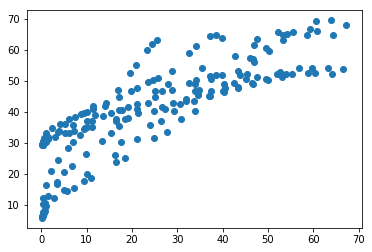

In [21]:
plt.scatter(target_yTest,predict_SVR)

##### Plot feature importance using built-in function 

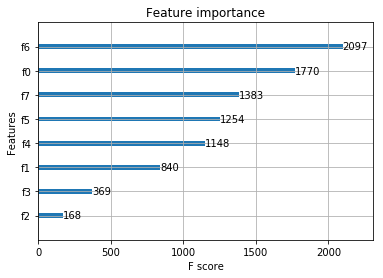

In [23]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(XGB)
pyplot.savefig('destination_path.pdf', format='pdf')
pyplot.show()

##### Rename the coloumn title

In [24]:
New_clip_filename.rename(columns={0:'Filename'}, inplace=True)
predict_LiReg.rename(columns={0:'Linear'}, inplace=True)

predict_XGB.rename(columns={0:'XGB'}, inplace=True)
predict_RF.rename(columns={0:'RF'}, inplace=True)

predict_SVR.rename(columns={0:'SVR'}, inplace=True)
target_yTest.rename(columns={0:'ActualVMAF'}, inplace=True)


##### Save the results as csv file

In [ ]:
target_yTest.to_csv('target_yTest.csv');
target_XTest.to_csv('target_XTest.csv');
predict_SVR.to_csv('predict_SVR.csv');
predict_LiReg.to_csv(' predict_LiReg.csv');
predict_RF.to_csv('predict_RF.csv');
predict_XGB.to_csv('predict_XGB.csv');
New_clip_filename.to_csv('New_clip_filename.csv');